
In this notebook, we will try the process of implementing RNN with Keras in order to classify text sentences.

I.   **Firstly**, we'll import useful packages.

II.   **Then**, we'll load the data and create a word embedding matrix using Glove.

III.  **We'll try a simple RNN model** and then we will evaluate its performances.

IV. Finally, we'll use techniques to increase our model's accuracy.

**Task 1:** Setting Fre GPU in this Google Colab notebook.

## Mounting Google Drive locally
**Task 2:** Mount the Google Driver into the Google Colab Driver.


In [ ]:
## TYPE YOUR CODE for task 2 here:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# I. Let import all useful packages.

In [ ]:
!pip install tensorflow_addons
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import tensorflow.keras
import datetime
from tensorflow.keras import backend as K
import tensorflow.keras.optimizers as Optimizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard,ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation,GRU,BatchNormalization
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, load_model,Sequential
import tensorflow_addons as tfa

from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from sklearn.metrics import confusion_matrix as CM
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plot
import seaborn as sn

     |████████████████████████████████| 706kB 8.2MB/s 


**Task 3**: Copy the dataset from Google Drive into Colab

In [ ]:
## TYPE YOUR CODE for task 3 here:
#/content/drive/MyDrive/Colab Notebooks/DeepLearning_Funix/train_ASS2.csv

# II. Load the data.

## About dataset.
An invalid question is defined as a question intended to make a statement rather than look for helpful answers. Some characteristics that can signify that a question is invalid:

* Has a non-neutral tone.
* Is disparaging or inflammatory.
* Isn't grounded in reality.
* Uses sexual content (incest, bestiality, pedophilia) for shock value, and not to seek genuine answers

The data includes the question that was asked, and whether it was identified as invalid (target = 1). 

**Task 4**: Load the dataset.
* Load the data from CSV file.
* Remove all the rows with NA values.
* Split the data into 3 set: Training set, validation set and test set (0.9/0.05/0.05, random_seed = 9) with a same ratio of data number beween each class.
* Print out these dataset's description.




In [ ]:
def load_data(data_link):
    '''
    input: data link.
    output:
        train_set, validation_set and test_set(0.95/0.05/0.05) without NA values.
    '''
    ## TYPE YOUR CODE for task 4 here:
    df=pd.read_csv(data_link)
    df.dropna(inplace=True)
    np.random.seed(9)
    x_train,x_test,y_train,y_test=train_test_split(df[['qid','question_text']],df[['target']],test_size=0.1,shuffle=True)
    x_val,x_test,y_val,y_test=train_test_split(x_test,y_test,test_size=0.5,shuffle=True)
    train=pd.concat([x_train,y_train],axis=1)
    test=pd.concat([x_test,y_test],axis=1)
    val=pd.concat([x_val,y_val],axis=1)
    return train,val,test

train_set, validation_set, test_set = load_data('/content/drive/MyDrive/Colab Notebooks/DeepLearning_Funix/train_ASS2.csv')
print(train_set['target'].describe())
print(validation_set['target'].describe())
print(test_set['target'].describe())

count    1.175509e+06
mean     6.185150e-02
std      2.408858e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: target, dtype: float64
count    65306.000000
mean         0.061602
std          0.240434
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: target, dtype: float64
count    65307.000000
mean         0.062474
std          0.242017
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: target, dtype: float64


# Encoding text data.
Let declare some fundamental parameters first:

In [ ]:
embed_size = 50 # how big is each word vector
max_features = 20000 # how many unique words to use (i.e num rows in embedding vector)
max_len = 50 # max number of words in a question to use


**Task 5:** Encode the dataset using Tokenizer and one-hot encoding vector.
* Encode the text (question_text column) by turning each question text into a list of word indexes using [Tokenizer](https://stackoverflow.com/questions/51956000/what-does-keras-tokenizer-method-exactly-do) with **max_features** and all the text sentences from the training and the validation set. 
* Turn each list of word indexes into an equal length - **max_len** (with truncation or padding as needed) using [pad_sequences](https://keras.io/preprocessing/sequence/).
* Encode the label (label column) using [to_categorical](https://keras.io/utils/) function on Keras.

In [ ]:

def encode(max_features,max_len,embed_size,train,val,test):
  
  tokenizer=Tokenizer(num_words=max_features)
  tokenizer.fit_on_texts(train['question_text'])
  tokenizer.fit_on_texts(val['question_text'])
  train_x=tokenizer.texts_to_sequences(train['question_text'])
  val_x=tokenizer.texts_to_sequences(val['question_text'])
  test_x=tokenizer.texts_to_sequences(test['question_text'])
  train_x=pad_sequences(train_x,maxlen=max_len)
  test_x=pad_sequences(test_x,maxlen=max_len)
  val_x=pad_sequences(val_x,maxlen=max_len)
  y_tr=to_categorical(train['target'],num_classes=2)
  y_va=to_categorical(val['target'],num_classes=2)
  y_te=test['target']
  return train_x,val_x,test_x,y_tr,y_va,y_te,tokenizer

X_tr,X_va,X_te,y_tr,y_va,y_te,tokenizer=encode(max_features,max_len,embed_size,train_set,validation_set,test_set)




**Task 6**: Create word embedding matrix.
* Firstly, write a function to [load the GloVe dictionary.](https://medium.com/analytics-vidhya/basics-of-using-pre-trained-glove-vectors-in-python-d38905f356db)
* Then, create a word embedding matrix using GloVe dictionary with these parameters:
    - Word embedding matrix shape: (Number of word, embed_size).
    - Embed size: 50.
    - Number of words: The minimum of (max_features, len(word_index)), while word_index is the dictionary of word which contains in tokenizer.
    - If a word occurs in GloVe dictionary, we should take its initialization value as in GloVe dictionary. Otherwise, take a normal random value with mean and std as mean and std of GloVe dictionary value.
    



In [ ]:

def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype='float32')
def get_GloVe_dict(GloVe_link):
    '''
    input: GloVe link.
    output: GloVe dictionary.
    '''
    ## TYPE YOUR CODE for task 6 here:
    with open(GloVe_link) as f :
     dic={}
     for line in f :
       line=line.split()
       word=line[0]
       value=np.array([float(x) for x in line[1:]])
       dic[word]=value
    return dic
GloVe_link = '/content/drive/MyDrive/Colab Notebooks/DeepLearning_Funix/ASS2_glove.6B.50d.txt'
GloVe_dict = get_GloVe_dict(GloVe_link)

In [ ]:
def create_embedding_matrix(GloVe_dict, tokenizer, max_features):
    '''
    input: GloVe dictionaray, tokenizer from training and validation dataset, number of max features.
    output: Word embedding matrix.
    '''
    
    ## TYPE YOUR CODE for task 6 here:
    glove_std=np.array([GloVe_dict[k] for k in GloVe_dict]).std()
    glove_mean=np.array([GloVe_dict[k] for k in GloVe_dict]).mean()
    word_index=tokenizer.word_index
    no_words = min(max_features, len(word_index))
    embedding_matrix=np.random.normal(glove_mean,glove_std,(no_words,embed_size))
    for i,word in word_index.items() :
      if word in GloVe_dict.keys() :
        embedded_vector=GloVe_dict.get(word)
        if embedded_vector != None :
          embedding_matrix[i]=embedded_vector

    return embedding_matrix

embedding_matrix = create_embedding_matrix(GloVe_dict, tokenizer, max_features)

III. Modelling
There are some steps we need to finish:
Build the model.

Compile the model.

Train / fit the data to the model.

Evaluate the model on the testing set.

## Build the model
**Task 7:** We can build an easy model composed of different layers such as:
* [Embedding](https://keras.io/layers/embeddings/) layer with max_features, embed_size and embedding_matrix.
* [Bidirectional LSTM layer](https://keras.io/examples/imdb_bidirectional_lstm/) with number of hidden state = 50, dropout_rate = 0.1 and recurrent_dropout_rate = 0.1.
* GlobalMaxPool1D.
* Dense with number of unit = 50, activation = 'relu'.
* Dropout with rate = 0.1.
* Final dense with number of unit = number of class, activation = 'sigmoid'.

In [ ]:
def create_model(max_len, max_features, embed_size):
    '''
    input: max_len, max_features, embed_size
    output: model.
    '''
    ## TYPE YOUR CODE for task 7 here:
    model= Sequential([
                       Embedding(input_dim=max_features,output_dim=embed_size,weights=[embedding_matrix]),
                       Bidirectional(LSTM(50,return_sequences=True,dropout=0.1,recurrent_dropout=0.1)),
                       GlobalMaxPool1D(),
                       Dense(50,activation='relu'),
                       Dropout(0.1),
                       Dense(2,'sigmoid')
                      ])
    
    return model

model = create_model(max_len, max_features, embed_size)

**Task 8:** Compile the model and setup the callback. Then print out the model summary.
* [Compile](https://keras.io/models/model/#compile) the model with Adam Optimizaer, lr = 1e-2, suitable loss for binary classification problem and ["F1-score"](https://github.com/tensorflow/addons/issues/825) as metric.
* Print out the model summary.

In [ ]:
def optimize(model):
    '''
    Input: 
        Model.
    Return: 
        Complied model.
    '''
    ## TYPE YOUR CODE for task 8 here:
    model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=1e-2),loss='binary_crossentropy',
                  metrics=['acc',tfa.metrics.FBetaScore(num_classes=2, average="macro")])
    return model

model = optimize(model)
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 50)          1000000   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 100)         40400     
_________________________________________________________________
global_max_pooling1d (Global (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 50)                5050      
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 102       
Total params: 1,045,552
Trainable params: 1,045,552
Non-trainable params: 0
______________________________________________

**Task 9**: Setup callback.
* Create the [tensorboard callback](https://www.tensorflow.org/tensorboard/tensorboard_in_notebooks) to save the logs.
* Create the [checkpoint callback](https://machinelearningmastery.com/check-point-deep-learning-models-keras/) to save the checkpoint with the best accuracy after each epoch.
* Create the [ReduceLROnPlateau](https://keras.io/callbacks/#reducelronplateau) callback with factor=0.3, patience=1 and "Validation F1-score" monitor.
* Create the [early stopping callback](https://keras.io/callbacks/#earlystopping) with patience=7, mode = 'max' and "Validation F1-score" monitor.



In [ ]:

def callback_model(checkpoint_name, log_names):
    '''
    Input: 
        Best checkpoint name, logs name.
    Return: 
        Callback list, which contains tensorboard callback and checkpoint callback.
    '''
    ## TYPE YOUR CODE for task 9 here:
    checkpoint=ModelCheckpoint(monitor='val_fbeta_score',filepath=checkpoint_name,save_best_only=True,mode='max')
    tfboard=TensorBoard(log_dir=log_names)
    RLR=ReduceLROnPlateau(monitor='val_fbeta_score',factor=0.3,patience=1,mode='max')
    earlystop=EarlyStopping(monitor='val_fbeta_score',patience=7,mode='max')
    callbacks_list=[checkpoint,tfboard,RLR,earlystop]
    return callbacks_list

checkpoint_name = 'weights.best.hdf5'
log_names = 'training_logs'
callbacks_list = callback_model(checkpoint_name, log_names)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 50)          1000000   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 100)         40400     
_________________________________________________________________
global_max_pooling1d (Global (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 50)                5050      
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 102       
Total params: 1,045,552
Trainable params: 1,045,552
Non-trainable params: 0
______________________________________________

**Task 10:** Train the model.

* Train the model with 20 epochs with batch_size = 4096.
* Return the model with best-checkpoint weights.

*Hint*: Fit the model first, then reload the model (load_model function) with best-checkpoint weights.

In [ ]:
def train_model(model, callbacks_list):
    '''
    Input: 
        Model and callback list,
    Return: 
        Model with best-checkpoint weights.
    '''
    ## TYPE YOUR CODE for task 10 here:
    history=model.fit(X_tr,y_tr,validation_data=(X_va,y_va),epochs=20,batch_size=4096,callbacks=callbacks_list)
    return model

model = train_model(model, callbacks_list)


Epoch 1/20
287/287 [==============================] - 1386s 5s/step - loss: 0.1949 - acc: 0.9235 - fbeta_score: 0.5896 - val_loss: 0.1121 - val_acc: 0.9554 - val_fbeta_score: 0.8015
Epoch 2/20
287/287 [==============================] - 1358s 5s/step - loss: 0.1088 - acc: 0.9550 - fbeta_score: 0.7792 - val_loss: 0.1094 - val_acc: 0.9573 - val_fbeta_score: 0.8084
Epoch 3/20
287/287 [==============================] - 1360s 5s/step - loss: 0.1021 - acc: 0.9590 - fbeta_score: 0.8062 - val_loss: 0.1076 - val_acc: 0.9576 - val_fbeta_score: 0.8068
Epoch 4/20
287/287 [==============================] - 1371s 5s/step - loss: 0.0935 - acc: 0.9621 - fbeta_score: 0.8246 - val_loss: 0.1105 - val_acc: 0.9574 - val_fbeta_score: 0.8166
Epoch 5/20
287/287 [==============================] - 1369s 5s/step - loss: 0.0898 - acc: 0.9636 - fbeta_score: 0.8353 - val_loss: 0.1115 - val_acc: 0.9582 - val_fbeta_score: 0.8089
Epoch 6/20
287/287 [==============================] - 1379s 5s/step - loss: 0.0855 - acc: 

In [ ]:
model.save('my_model')
new_model=load_model('my_model')

**Task 11:** Show the tensorboard in the notebook.

In [ ]:
## TYPE YOUR CODE for task 11 here:
from tensorboard import notebook
notebook.list()


**Task 12:** Prediction on test set.

* Complete the get_prediction_classes function.
* Print out the precision, recall and F1 score.

In [ ]:
def get_prediction_classes(model, X, y):
    ## TYPE YOUR CODE for task 13 here:
    '''
    Input: 
        Model and prediction dataset.
    Return: 
        Prediction list and groundtrurth list with predicted classes.
    '''
    predictions=np.argmax(model.predict(X),axis=1)
    groundtruths=y
    return predictions, groundtruths

test_predictions, test_groundtruths = get_prediction_classes(model,  X_te, y_te)

print(precision_score(test_predictions, test_groundtruths))
print(recall_score(test_predictions, test_groundtruths))
print(f1_score(test_predictions, test_groundtruths))

0.6105392156862746
0.6538057742782152
0.6314321926489227


**Task 13:** Perform the predicted result on test set using confusion matrix. Remember to show the class name in the confusion matrix.

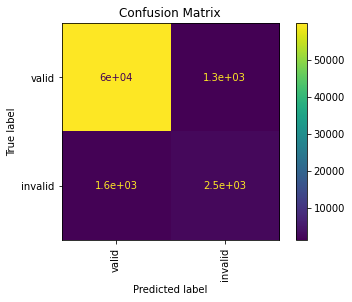

In [ ]:
    ## TYPE YOUR CODE for task 13 here:
def plot_confusion_matrix(predictions, groundtruth, class_names):

  from sklearn.metrics import  ConfusionMatrixDisplay
  cm = confusion_matrix(groundtruth,predictions)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names)
  
  disp.plot(include_values=True,xticks_rotation='vertical')
  plot.title('Confusion Matrix')
  plot.show()   

class_names = ['valid', 'invalid']
plot_confusion_matrix(test_predictions, test_groundtruths, class_names)

**Task 14**: Model finetuning - fine tune the model using some of these approachs:
* Increase max epochs, change batch size.
* Replace LSTM by GRU units and check if it changes anything.
* Add another layer of LSTM/GRU, see if things improve.
* Play around with Dense layers (add/# units/etc).
* Find preprocessing rules you could add to improve the quality of the data.
* Find another GloVe dictionary.
Requirement: The F1 score should increase by 2-3%.

In [ ]:
## TYPE YOUR CODE for task 14 here:
def create_sota(max_len, max_features, embed_size):
    model= Sequential([
                       Embedding(input_dim=max_features,output_dim=embed_size,weights=[embedding_matrix]),
                       Bidirectional(GRU(50,return_sequences=True,dropout=0.3,recurrent_dropout=0.3)),
                       Bidirectional(GRU(50,return_sequences=True,dropout=0.3,recurrent_dropout=0.3)),
                       GlobalMaxPool1D(),
                       Dense(50,activation='relu'),
                       Dropout(0.3),
                       BatchNormalization(),
                       Dense(2,'sigmoid')
                      ])
    
    return model
sota=create_sota(max_len, max_features, embed_size)
sota=optimize(sota)
history=sota.fit(X_tr,y_tr,validation_data=(X_va,y_va),epochs=30,batch_size=4096,callbacks=callbacks_list)

Epoch 1/30
287/287 [==============================] - 299s 1s/step - loss: 0.2339 - acc: 0.9133 - fbeta_score: 0.6251 - val_loss: 0.1124 - val_acc: 0.9559 - val_fbeta_score: 0.7775
Epoch 2/30
287/287 [==============================] - 279s 974ms/step - loss: 0.1136 - acc: 0.9540 - fbeta_score: 0.7649 - val_loss: 0.1107 - val_acc: 0.9558 - val_fbeta_score: 0.8092
Epoch 3/30
287/287 [==============================] - 279s 972ms/step - loss: 0.1088 - acc: 0.9557 - fbeta_score: 0.7794 - val_loss: 0.1100 - val_acc: 0.9573 - val_fbeta_score: 0.8047
Epoch 4/30
287/287 [==============================] - 277s 966ms/step - loss: 0.1032 - acc: 0.9582 - fbeta_score: 0.7945 - val_loss: 0.1100 - val_acc: 0.9579 - val_fbeta_score: 0.7936
Epoch 5/30
287/287 [==============================] - 282s 982ms/step - loss: 0.0999 - acc: 0.9593 - fbeta_score: 0.8021 - val_loss: 0.1111 - val_acc: 0.9582 - val_fbeta_score: 0.8008
Epoch 6/30
287/287 [==============================] - 285s 993ms/step - loss: 0.099

In [ ]:
!rm -rf training_log

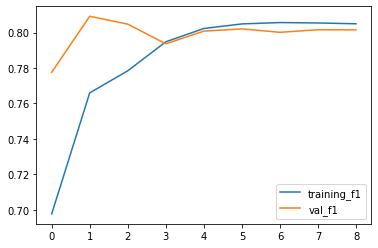

In [ ]:
hist_val=history.history
plot.plot(hist_val['fbeta_score'],label='training_f1')
plot.plot(hist_val['val_fbeta_score'],label='val_f1')
plot.legend(loc='lower right')

In [ ]:
def get_prediction_classes(model, X, y):
    predictions=np.argmax(model.predict(X),axis=1)
    groundtruths=y
    return predictions, groundtruths

sota_pred, sota_groundtruths = get_prediction_classes(sota,  X_te, y_te)

print(f1_score(sota_pred, sota_groundtruths))